<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 4
%autosave 120

Autosaving every 120 seconds


In [1]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)


Using TensorFlow backend.


In [2]:
import feather

In [11]:
from fastai.io import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from pandas_summary import DataFrameSummary
from IPython.display import display
from sklearn import metrics
import feather
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
import warnings

In [3]:
data = feather.read_dataframe('train_df_beta')

In [4]:
for df in [data]:
    for f in ['purchase_date_max','purchase_date_min','purchase_date_max_old',\
                     'purchase_date_min_old']:
        df[f] = df[f].astype(np.int64) * 1e-9

In [5]:
data.head().T

,0,1,2,3,4
first_active_month,2017-06-01 00:00:00,2017-01-01 00:00:00,2016-08-01 00:00:00,2017-09-01 00:00:00,2017-11-01 00:00:00
card_id,C_ID_92a2005557,C_ID_3d0044924f,C_ID_d639edf6cd,C_ID_186d6a6901,C_ID_cdbd2c0db2
feature_1,0.0131446,0.0107116,0.0106099,0.0107116,0.00805849
feature_2,0.00875212,0.0113848,0.00875212,0.0141664,0.0141664
feature_3,0.0114275,0.0102828,0.0102828,0.0102828,0.0102828
target,-0.820283,0.392913,0.688056,0.142495,-0.159749
first_active_monthYear,2017,2017,2016,2017,2017
first_active_monthMonth,6,1,8,9,11
first_active_monthWeek,22,52,31,35,44
first_active_monthDay,1,1,1,1,1


In [6]:
train_columns = [c for c in data.columns if c not in ['card_id', 'first_active_month','target','outliers']]

In [7]:
vc = data['outliers'].value_counts().to_frame().reset_index()
vc['percent'] = vc["outliers"].apply(lambda x : round(100*float(x) / len(data), 2))
vc = vc.rename(columns = {"index" : "target", "outlier" : "Count"})
vc

,target,outliers,percent
0,0,199710,98.91
1,1,2207,1.09


In [52]:
non_fraud = data[data['outliers'] == 0].sample(8000)
fraud = data[data['outliers'] == 1]

In [28]:
non_fraud.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,first_active_monthYear,first_active_monthMonth,first_active_monthWeek,first_active_monthDay,...,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio,feature_sum,feature_prod,feature_mean,feature_max,feature_min,feature_var
124874,2017-07-01,C_ID_c530e827e8,0.010712,0.014166,0.010283,-0.548144,2017,7,26,1,...,0,0.006791,0.005093,0.000000,7,0,2.333333,4,0,2.081666
139654,2017-03-01,C_ID_379b320fe9,0.010479,0.011385,0.011428,-0.514832,2017,3,9,1,...,711,0.004219,0.001406,0.001406,5,3,1.666667,3,1,1.154701
5472,2016-07-01,C_ID_8dddcf7886,0.013145,0.011385,0.011428,-1.448466,2016,7,26,1,...,954,0.005241,0.001048,0.001048,7,5,2.333333,5,1,2.309401
70959,2017-02-01,C_ID_9293ff84a9,0.010610,0.011385,0.010283,-1.723487,2017,2,5,1,...,0,0.002706,0.001353,0.000000,3,0,1.000000,2,0,1.000000
142473,2017-11-01,C_ID_f9ad9dd066,0.008058,0.014166,0.010283,2.542625,2017,11,44,1,...,0,0.002146,0.006438,0.000000,4,0,1.333333,3,0,1.527525


In [29]:
fraud.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,first_active_monthYear,first_active_monthMonth,first_active_monthWeek,first_active_monthDay,...,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio,feature_sum,feature_prod,feature_mean,feature_max,feature_min,feature_var
64,2017-09-01,C_ID_8186f3fcc1,0.010479,0.011385,0.011428,-33.219281,2017,9,35,1,...,527,0.005693,0.001898,0.001898,5,3,1.666667,3,1,1.154701
92,2015-05-01,C_ID_b9379a30ea,0.010479,0.014166,0.011428,-33.219281,2015,5,18,1,...,1381,0.002172,0.002172,0.000724,7,9,2.333333,3,1,1.154701
125,2015-10-01,C_ID_e9120f535c,0.010479,0.014166,0.011428,-33.219281,2015,10,40,1,...,1228,0.002443,0.002443,0.000814,7,9,2.333333,3,1,1.154701
151,2017-03-01,C_ID_65715cb80d,0.010712,0.008752,0.010283,-33.219281,2017,3,9,1,...,0,0.005626,0.002813,0.000000,6,0,2.000000,4,0,2.000000
225,2017-01-01,C_ID_ae77d244b6,0.010610,0.011385,0.010283,-33.219281,2017,1,52,1,...,0,0.002597,0.001299,0.000000,3,0,1.000000,2,0,1.000000


In [30]:
DataFrameSummary(non_fraud).summary().T

/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/numpy/lib/function_base.py:3768: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
first_active_month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000,61,0,0%,date
card_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000,4000,0,0%,unique
feature_1,4000,0.010958,0.0012535,0.00805849,0.0104794,0.0106099,0.0107116,0.0131446,4000,5,0,0%,numeric
feature_2,4000,0.0109406,0.00194276,0.00875212,0.00875212,0.0113848,0.0113848,0.0141664,4000,3,0,0%,numeric
feature_3,4000,0.0109413,0.000565895,0.0102828,0.0102828,0.0114275,0.0114275,0.0114275,4000,2,0,0%,bool
target,4000,-0.0563465,1.71308,-10.0498,-0.872702,-0.00405931,0.772661,10.1888,4000,3962,0,0%,numeric
first_active_monthYear,4000,2016.52,0.767591,2011,2016,2017,2017,2017,4000,7,0,0%,numeric
first_active_monthMonth,4000,7.44775,3.32296,1,5,8,10,12,4000,12,0,0%,numeric
first_active_monthWeek,4000,31.313,13.6765,1,22,31,44,53,4000,21,0,0%,numeric
first_active_monthDay,4000,1,0,1,1,1,1,1,4000,1,0,0%,constant


In [31]:
DataFrameSummary(fraud).summary().T

,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
first_active_month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2207,65,0,0%,date
card_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2207,2207,0,0%,unique
feature_1,2207,0.0110753,0.0012774,0.00805849,0.0104794,0.0106099,0.0107116,0.0131446,2207,5,0,0%,numeric
feature_2,2207,0.011279,0.00198159,0.00875212,0.00875212,0.0113848,0.0113848,0.0141664,2207,3,0,0%,numeric
feature_3,2207,0.0109597,0.000562848,0.0102828,0.0102828,0.0114275,0.0114275,0.0114275,2207,2,0,0%,bool
target,2207,-33.2193,7.10704e-15,-33.2193,-33.2193,-33.2193,-33.2193,-33.2193,2207,1,0,0%,constant
first_active_monthYear,2207,2016.19,0.950668,2012,2016,2016,2017,2017,2207,6,0,0%,numeric
first_active_monthMonth,2207,6.31264,3.51143,1,3,6,9,12,2207,12,0,0%,numeric
first_active_monthWeek,2207,28.2981,15.3947,1,13,26,44,53,2207,21,0,0%,numeric
first_active_monthDay,2207,1,0,1,1,1,1,1,2207,1,0,0%,constant


In [53]:
df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['card_id', 'first_active_month','target','outliers'], axis = 1).values
Y = df["outliers"].values

In [54]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X = imp.fit_transform(X)

/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


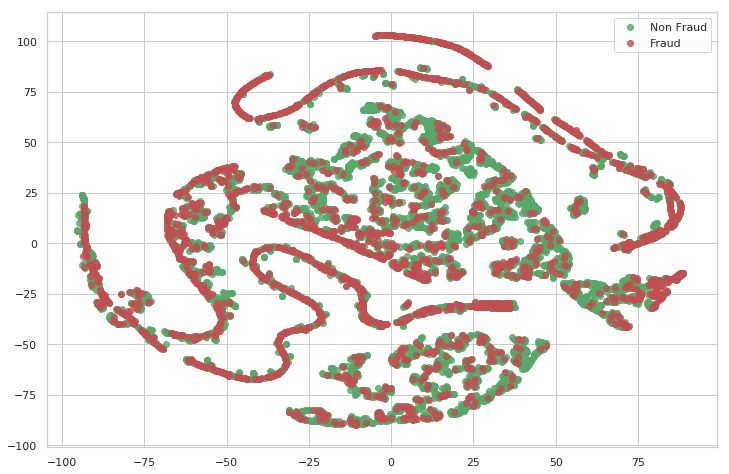

In [55]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, Y, "original.png")

In [56]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [57]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [58]:
x = data.drop(['card_id', 'first_active_month','target','outliers'], axis=1)
y = data["outliers"].values

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
x = imp.fit_transform(x)

/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


In [59]:
x.shape, y.shape

((201917, 267), (201917,))

In [60]:
x_scale = preprocessing.MinMaxScaler().fit_transform(x)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

In [67]:
autoencoder.fit(x_norm[0:8000], x_norm[0:8000], 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);

Train on 6400 samples, validate on 1600 samples
Epoch 1/10
6400/6400 [==============================] - 5s 858us/step - loss: 0.2725 - val_loss: 0.2877
Epoch 2/10
6400/6400 [==============================] - 5s 794us/step - loss: 0.2949 - val_loss: 0.2921
Epoch 3/10
6400/6400 [==============================] - 6s 869us/step - loss: 0.3037 - val_loss: 0.3000
Epoch 4/10
6400/6400 [==============================] - 6s 863us/step - loss: 0.3103 - val_loss: 0.3065
Epoch 5/10
6400/6400 [==============================] - 5s 820us/step - loss: 0.3158 - val_loss: 0.3100
Epoch 6/10
6400/6400 [==============================] - 5s 738us/step - loss: 0.3195 - val_loss: 0.3072
Epoch 7/10
6400/6400 [==============================] - 5s 851us/step - loss: 0.3229 - val_loss: 0.3051
Epoch 8/10
6400/6400 [==============================] - 6s 882us/step - loss: 0.3258 - val_loss: 0.3230
Epoch 9/10
6400/6400 [==============================] - 6s 878us/step - loss: 0.3298 - val_loss: 0.3182
Epoch 10/10
6400

In [68]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [69]:
norm_hid_rep = hidden_representation.predict(x_norm[:6000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

In [71]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

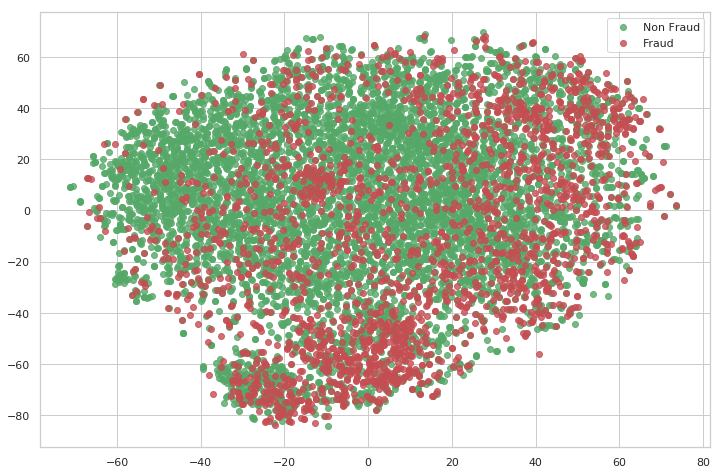

In [72]:
tsne_plot(rep_x, rep_y, "latent_representation.png")

In [65]:
from IPython.display import display, Image, HTML
display(HTML("""<table align="center">
<tr ><td><b>Actual Representation (Before) </b></td><td><b>Latent Representation (Actual)</b></td></tr>
<tr><td><img src='original.png'></td><td>
             <img src='latent_representation.png'></td></tr></table>"""))


Actual Representation (Before),Latent Representation (Actual)
,


In [73]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.77      0.94      0.85      1505
         1.0       0.60      0.24      0.34       547

   micro avg       0.75      0.75      0.75      2052
   macro avg       0.69      0.59      0.60      2052
weighted avg       0.73      0.75      0.71      2052


Accuracy Score:  0.7548732943469786
